# TM10007 Assignment

In [ ]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [25]:
# Libraries
import pandas as pd


from worcgist.load_data import load_data

In [26]:
# Load data
data = load_data()

data['label'] = data['label'].map({'non-GIST': 0, 'GIST': 1})

y = data['label']
x = data.drop(columns=['label'])

# Calculate basic statistics
n_samples = len(y)
n_features = len(x.columns)

n_missing = data.isna().sum().sum()
n_zero = (data == 0).sum().sum()

# Print basic statistics
print(f'The number of samples: {n_samples}')
print(f'The number of features: {n_features}')
print(f'The number of datapoints: {n_samples * n_features}')
print(f"The number of missing values: {n_missing}")
print(f"The number of zero values: {n_zero}")

data.info()
data.describe()
data.duplicated()

The number of samples: 246
The number of features: 493
The number of datapoints: 121278
The number of missing values: 0
The number of zero values: 6848
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, GIST-001_0 to GIST-246_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(26)
memory usage: 951.3+ KB


ID
GIST-001_0    False
GIST-002_0    False
GIST-003_0    False
GIST-004_0    False
GIST-005_0    False
              ...  
GIST-242_0    False
GIST-243_0    False
GIST-244_0    False
GIST-245_0    False
GIST-246_0    False
Length: 246, dtype: bool

## Pre-processing

In [50]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=50)  # or 50, or try multiple values
x_reduced_array = selector.fit_transform(x, y)
selected_feature_names = x.columns[selector.get_support()]
x_reduced = pd.DataFrame(x_reduced_array, columns=selected_feature_names)
print(x_reduced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 50 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   PREDICT_original_sf_rad_dist_avg_2.5D                         246 non-null    float64
 1   PREDICT_original_sf_rad_dist_std_2.5D                         246 non-null    float64
 2   PREDICT_original_sf_area_avg_2.5D                             246 non-null    float64
 3   PREDICT_original_sf_area_std_2.5D                             246 non-null    float64
 4   PREDICT_original_hf_median                                    246 non-null    float64
 5   PREDICT_original_logf_entropy_sigma1                          246 non-null    float64
 6   PREDICT_original_logf_entropy_sigma5                          246 non-null    float64
 7   PREDICT_original_logf_entropy_sigma10                         246 non-n

c:\Users\lucas\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 77  84  90  97 103 110 467 474 475 480 487 488] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\lucas\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


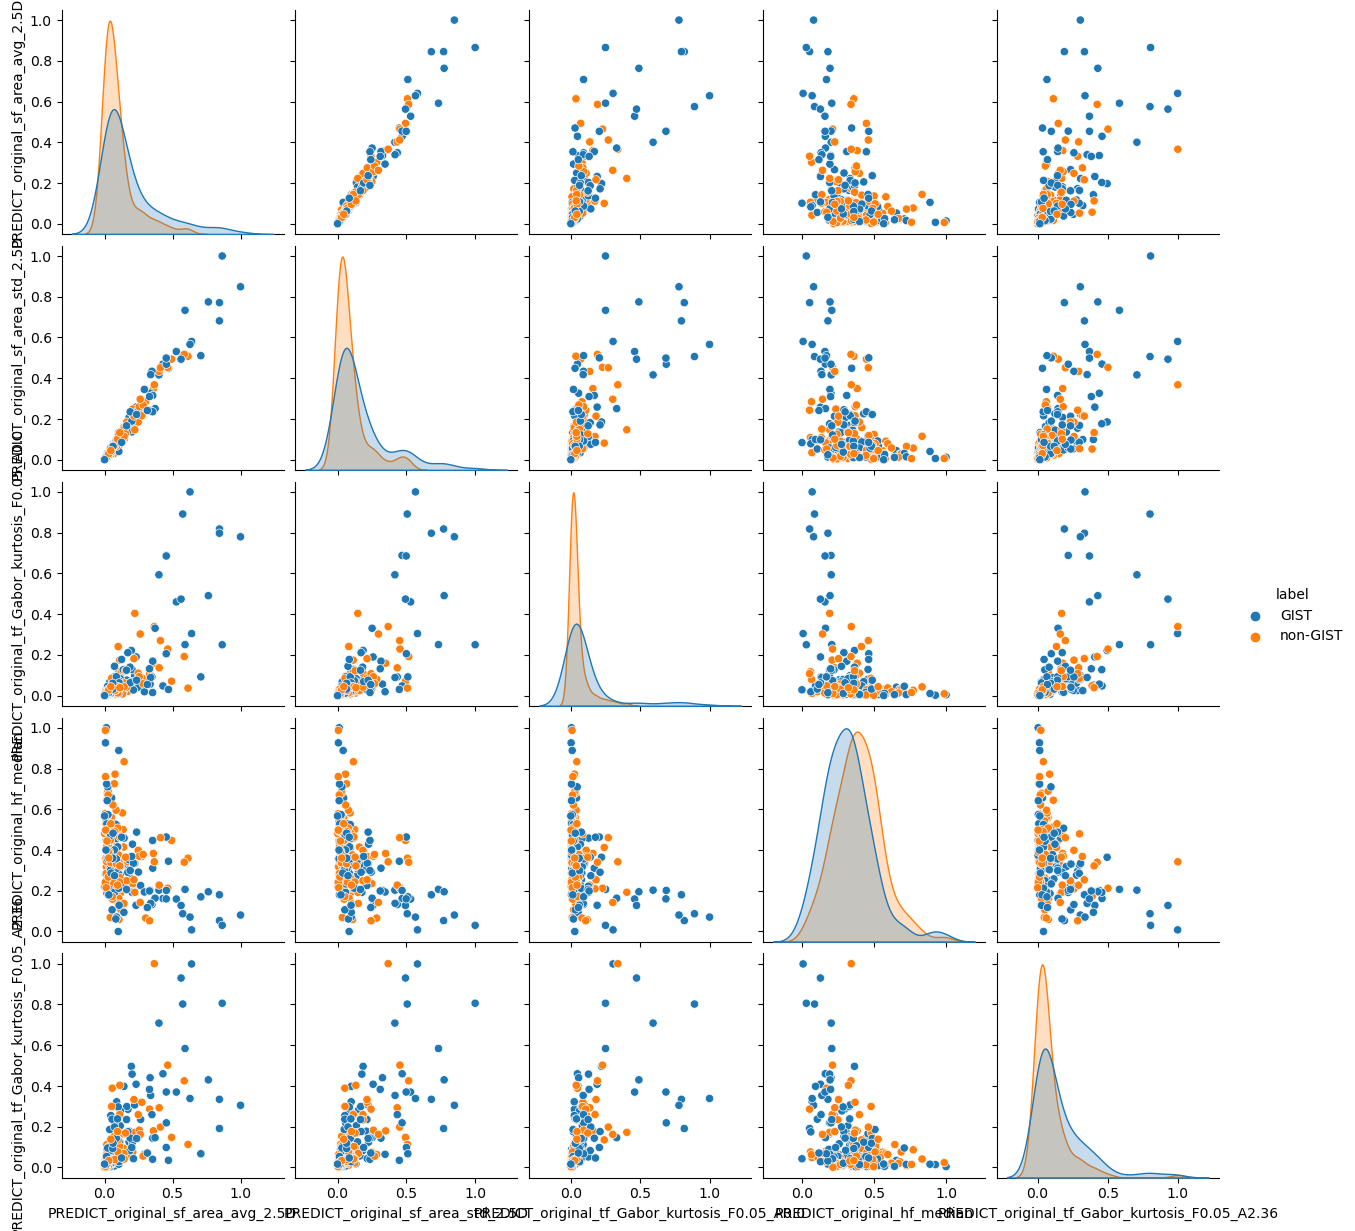

In [51]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Calculate variance for each feature
feature_variances = x_reduced.var()

# Select the top 5 features with the highest variance
top_features = feature_variances.nlargest(5).index

# Normalize the selected features
scaler = MinMaxScaler()
x_reduced[top_features] = scaler.fit_transform(x_reduced[top_features])

# Merge the top features with the label
merged_data = pd.concat([x_reduced[top_features], y.reset_index(drop=True).map({0: 'non-GIST', 1: 'GIST'}).rename('label')], axis=1)

# Create a seaborn pairplot for the top features with colors based on labels
sns.pairplot(merged_data, hue='label', diag_kind="kde")
plt.show()


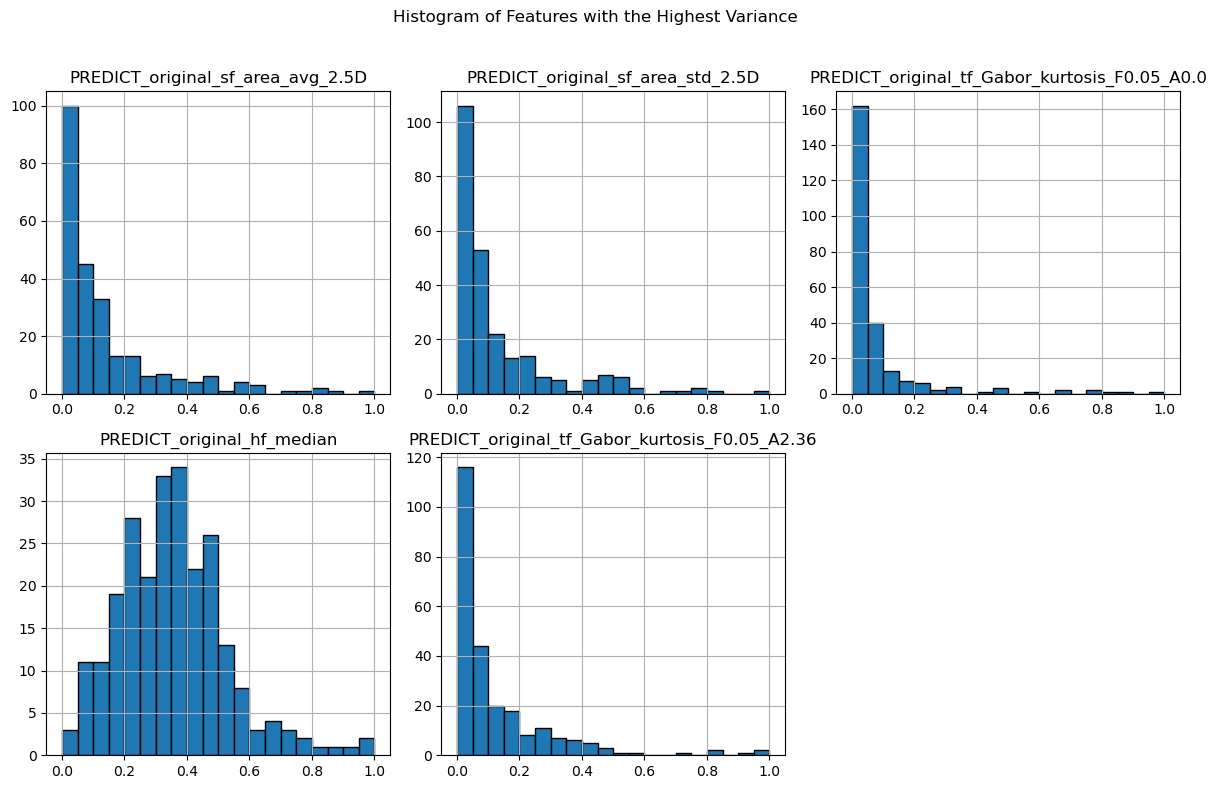

In [53]:
# Histogram of the features with the highest variance
x_reduced[top_features].hist(bins=20, figsize=(12, 8), layout=(2, 3), edgecolor='black')
plt.suptitle("Histogram of Features with the Highest Variance")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
from scipy.stats import zscore

# Outlier removal based on normal-distribution assumption

def replace_outliers(df, is_normal):
    """
    Replace outliers in the given DataFrame based on the distribution type of each column.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing numerical data.
    is_normal (pd.Series): A Series indicating whether each column in the DataFrame is normally distributed (True) or not (False).

    Returns:
    pd.DataFrame: The DataFrame with outliers replaced by the respective bounds.
    """
    threshold_nd = 3
    threshold_nnd = 1.5
    for column in df.columns:
        if is_normal[column]:
            # Use z-score for normally distributed columns
            mean = df[column].mean()
            std = df[column].std()
            lower_bound = mean - threshold_nd * std
            upper_bound = mean + threshold_nd * std
            outliers = (df[column] > upper_bound) | (df[column] < lower_bound)
            df.loc[df[column] > upper_bound, column] = upper_bound
            df.loc[df[column] < lower_bound, column] = lower_bound
        else:
            # Use IQR for non-normally distributed columns
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold_nnd * IQR
            upper_bound = Q3 + threshold_nnd * IQR
            outliers = (df[column] > upper_bound) | (df[column] < lower_bound)
            df.loc[df[column] > upper_bound, column] = upper_bound
            df.loc[df[column] < lower_bound, column] = lower_bound
    return df
